# **Identifying Nutrient Deficiencies in Satellite Farmland Imagery**
## 03: Model Evaluation

In this notebook, I'll evaluate a few different model specifications for the binary semantic segmentation task:
* **UNET with RGB-only image data** using **binary crossentropy** loss
* **UNET with RGB-only image data** using **Jaccard** (AKA Intersection over Union) loss
* **UNET with RGB AND Near-Infrared image data** using **Jaccard** (AKA Intersection over Union) loss.


For basic classification tasks, classification accuracy measured against the ground truth labels would be the a primary metric of interest in evaluating model performance. However, as illustrated in [this post](#), accuracy may not be the best metric for evaluating a binary semantic segmentation model. Instead, I'll be using **Intersection Over Union**, otherwise known as the **Jaccard Distance** (or Coefficient), which is the better metric for when the classes are as imbalanced as they can be in this type of semantic segmentation task.

### Note on model training

Despite UNET being a somewhat lightweight model architecture, the training for the ~12GB of image data, comprised of 14,712 satellite agriculture images meant that efficiently training the model would require some assistance from GPU acceleration. As such, the model training was performed in two Google Colab notebooks:
* [UNET_RGB_Model_Training](UNET_RGB_Model_Training.ipynb) and
* [UNET_Multispectral_Model_Training](UNET_Multispectral_Model_Training.ipynb).

Instructions for running those notebooks is documented in [Data Retrieval and Model Training Setup](../Data_Retrieval_and_Model_Training_Setup.md). The output of the model training was UNET model weights, which we'll load in this notebook to produce the image segmentation predictions for evaluation in this notebook.

---

### Library, Module, and Function Imports

Start with some necessary imports:

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
np.random.seed(42)

#some image processing modules:
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

#some tensorflow.keras modules:
from tensorflow import math as tf
from tensorflow.keras import metrics
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

#import UNET model architecture functions from UNET.py
from UNET import conv2d_block, get_unet, jaccard_coef, jaccard_coef_loss

### Load the image data

Next, we need to load in the image data:

In [94]:
#set some parameters:
im_width, im_height = (128,128)

#import metadata for image names:
df = pd.read_csv('../data/image_metadata_with_clusters.csv')

#get image ids
ids = [x+'.jpg' for x in df['image_name']]
print('No. of images:', len(ids))

#test size for the model training was 10% of the total image population, so we'll review the
#predictive performance for the same set of images:
test_size = 0.1
split = int(len(ids)*(1-test_size))
ids = ids[split:]
print('No of evaluation images:',len(ids))

#also update the dataframe to only keep the image name and metadata for the evaluation set:
df = df.loc[split:]

#create empty X and y containers:
X = np.zeros((len(ids), im_height, im_width, 4), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

#load image data into the containers:
for n, id_ in enumerate(ids):
    #load images
    x_img = img_to_array(load_img('../data/features/'+id_,color_mode='rgb'))
    x_img = resize(x_img, (im_width,im_height,3), mode='constant',preserve_range=True)
    #load nir channel
    x_nir = img_to_array(load_img('../data/nir_features/'+id_,color_mode='grayscale'))
    x_nir = resize(x_nir, (im_width,im_height,1), mode='constant',preserve_range=True)
    
    #combine img and nir into 4-channel image arrays:
    x_img = np.concatenate((x_img,x_nir),axis=2)
    
    #load masks:
    mask = img_to_array(load_img('../data/labels/'+id_.replace('.jpg','.png'),color_mode='grayscale'))
    mask = resize(mask,(im_width,im_height,1), mode='constant',preserve_range=True)
    #save and scale them:
    X[n] = x_img/255.0
    y[n] = mask/255.0

print(f'Shape of X: {X.shape} (fourth chanel is Near-Infrared)')
print(f'Shape of y: {y.shape}')

No. of images: 14712
No of evaluation images: 1472
Shape of X: (1472, 128, 128, 4) (fourth chanel is Near-Infrared)
Shape of y: (1472, 128, 128, 1)


In [3]:
df.head()

nutrient_deficiency  image_area  nutrient_deficiency_area  \
13240                    1    196096.0                   25850.0   
13241                    1    262144.0                   70288.0   
13242                    1    237540.0                  157168.0   
13243                    1    262144.0                  180369.0   
13244                    4    215568.0                    7529.0   

                            image_name  cluster  
13240    RJNBD4IVU_7748-3240-8260-3752        1  
13241    TD2VA2KJW_1148-2562-1660-3074        2  
13242     4GTVV9N4F_786-6105-1298-6617        2  
13243  3MU7MFDEC_5155-12551-5667-13063        2  
13244    UVYD7NE6L_9399-3837-9911-4349        2

In [4]:
df = df.reset_index().drop(columns=['index'])
df['nutrient_image_ratio'] = df['nutrient_deficiency_area']/df['image_area']
display(df.shape)

(1472, 6)

---
### Define the models


With the image data loaded, we now need to define the three models:
* **UNET with RGB-only image data** using **binary crossentropy** loss
* **UNET with RGB-only image data** using **Jaccard** (AKA Intersection over Union) loss
* **UNET with RGB AND Near-Infrared image data** using **Jaccard** (AKA Intersection over Union) loss.

Note that the RGB UNET models expect the X data shape to be 128x128x3, but we've loaded the image data in to be 4-channel tensors.
Prediction and evaluation calls will need to specify the first 3 channels of the feature matrix only.

This is how that call is made: `X[...,:3]`

**UNET with RGB-only image data** using **binary crossentropy** loss:

In [5]:
input_img = Input((im_height, im_width, 3), name='img')
RGB_UNET_BCE = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
RGB_UNET_BCE.compile(optimizer=Adam(), loss=['binary_crossentropy'], metrics=[jaccard_coef, 'accuracy'])
RGB_UNET_BCE.load_weights('../output/best_model_weights/rgb_nutrient_deficiency_identifier_BCE.h5')

**UNET with RGB-only image data** using **Jaccard** (AKA Intersection over Union) loss:

In [6]:
#input_img parameters not different than the model above
RGB_UNET_IOU = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
RGB_UNET_IOU.compile(optimizer=Adam(), loss=[jaccard_coef_loss], metrics=[jaccard_coef,'accuracy'])
RGB_UNET_IOU.load_weights('../output/best_model_weights/rgb_nutrient_deficiency_identifier_JACCARD.h5')

**UNET with RGB AND Near-Infrared image data** using **Jaccard** (AKA Intersection over Union) loss:

In [7]:
input_img = Input((im_height, im_width, 4), name='img')
Multispectral_UNET_IOU = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
Multispectral_UNET_IOU.compile(optimizer=Adam(), loss=[jaccard_coef_loss], metrics=[jaccard_coef,'accuracy'])
Multispectral_UNET_IOU.load_weights('../output/best_model_weights/multispectral_nutrient_deficiency_identifier_JACCARD.h5')

Next, get predictions:


In [8]:
#classification confidence (between 0 and 1):
RGB_BCE_preds = RGB_UNET_BCE.predict(X[...,:3])
RGB_IOU_preds = RGB_UNET_IOU.predict(X[...,:3])
MS_IOU_preds = Multispectral_UNET_IOU.predict(X)

In [10]:
#obtain accuracies:
acc_RGB_BCE = RGB_UNET_BCE.evaluate(X[...,:3],y)[2]
acc_RGB = RGB_UNET_IOU.evaluate(X[...,:3],y)[2]
acc_MS = Multispectral_UNET_IOU.evaluate(X,y)[2]

46/46 [==============================] - 17s 380ms/step - loss: -0.4864 - jaccard_coef: 0.4864 - accuracy: 0.6984


In [100]:
#get baseline accuracy:
baseline_y = np.zeros((1472,128,128,1),dtype=np.uint8)+1
correct = np.sum(baseline_y == y) #the number of pixels that are 1 in baseline vs actually 1 in labels
total = y.shape[0]*y.shape[1]*y.shape[2] #num_images * image width * image height = number of pixels
acc_baseline = correct/total

In [101]:
def calculate_ious(y_true,y_pred):
    pred_iou = []
    for img in range(len(y_true)):
        intersection = np.logical_and(y_true[img],y_pred[img])
        union = np.logical_or(y_true[img],y_pred[img])
        pred_iou.append(np.sum(intersection)/np.sum(union))
    return pred_iou

In [102]:
threshold = 0.5
#the preds need to be binarized via comparison to a set threshold.
#if the pred strength is greater than 0.5, we'll say the pixel belongs to the nutrient deficiency class;
#otherwise, it won't.
preds = {
    'IOU_RGB_BCE': (RGB_BCE_preds > threshold).astype(np.uint8),
    'IOU_RGB': (RGB_IOU_preds > threshold).astype(np.uint8),
    'IOU_MS': (MS_IOU_preds > threshold).astype(np.uint8),
    'IOU_Baseline': baseline_y
}

for pred in preds:
    df[pred] = calculate_ious(y,preds[pred])

df.head()

nutrient_deficiency  image_area  nutrient_deficiency_area  \
13240                    1    196096.0                   25850.0   
13241                    1    262144.0                   70288.0   
13242                    1    237540.0                  157168.0   
13243                    1    262144.0                  180369.0   
13244                    4    215568.0                    7529.0   

                            image_name  cluster  IOU_RGB_BCE   IOU_RGB  \
13240    RJNBD4IVU_7748-3240-8260-3752        1     0.150439  0.163459   
13241    TD2VA2KJW_1148-2562-1660-3074        2     0.471951  0.335009   
13242     4GTVV9N4F_786-6105-1298-6617        2     0.521444  0.638564   
13243  3MU7MFDEC_5155-12551-5667-13063        2     0.050616  0.666503   
13244    UVYD7NE6L_9399-3837-9911-4349        2     0.744277  0.678872   

         IOU_MS  IOU_Baseline  
13240  0.361694      0.115845  
13241  0.389573      0.284729  
13242  0.597721      0.628906  
13243  0.672819      0.713074  
13244  0.542347      0.468872

In [103]:
results = {
    'RGB_BCE': {},
    'RGB': {},
    'MS': {},
    'baseline': {}
}

results['RGB_BCE']['accuracy'] = acc_RGB_BCE
results['RGB_BCE']['IoU'] = df['IOU_RGB_BCE'].mean()
results['RGB']['accuracy'] = acc_RGB
results['RGB']['IoU'] = df['IOU_RGB'].mean()
results['MS']['accuracy'] = acc_MS
results['MS']['IoU'] = df['IOU_MS'].mean()
results['baseline']['accuracy'] = acc_baseline
results['baseline']['IoU'] = df['IOU_Baseline'].mean()
results = pd.DataFrame(results).T

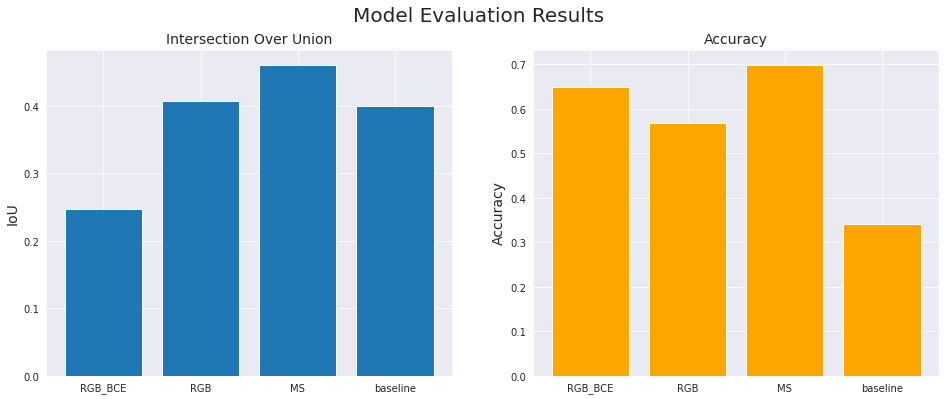

In [104]:
with sns.axes_style('darkgrid'):
    fig, axs = plt.subplots(1,2,figsize=(16,6))
    fig.suptitle('Model Evaluation Results',size=20)
    axs[0].bar(results.index,results['IoU'])
    axs[0].set_title('Intersection Over Union',size=14)
    axs[0].set_ylabel('IoU',size=14)
    axs[1].bar(results.index,results['accuracy'],color='orange')
    axs[1].set_ylabel('Accuracy',size=14)
    axs[1].set_title('Accuracy',size=14)
    plt.savefig('../images/evaluation_results.png');

The chart above demonstrates that not only does the multispectral-input model outperform the baseline in Intersection over Union, it outperforms in validation accuracy compared to the basline and the RGB model which was trained on minimizing the binary crossentropy.

Compared to the RGB-only model, the above demonstrates that the added information of having the near-infrared 'color' channel aides the model in identifying areas with nutrient deficiency.

---

### Inspecting predictions

Sorting by the IoU metric for our best-performing model, let's review how the models predicted on several examples of the validation images.

In [70]:

#make into binary predictions:
threshold = 0.5
RGB_BCE_preds = (RGB_BCE_preds > threshold).astype(np.uint8)
RGB_IOU_preds = (RGB_IOU_preds > threshold).astype(np.uint8)
MS_IOU_preds = (MS_IOU_preds > threshold).astype(np.uint8)

#define a helper function for plotting:
def get_iou(dataframe,ix,model=0):
    if model not in [0,1,2]:
        return 'Pick any value between 0,1,2 for `model`'
    models = ['IOU_MS','IOU_RGB','IOU_RGB_BCE']
    return dataframe.loc[ix,models[model]]

#define a plotting function:
def plot_sample(dataframe,ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))
    this_name = f"{dataframe.loc[ix,'image_name']}.jpg"
    this_cluster = f"{dataframe.loc[ix,'cluster']}"
    this_ratio = f"{dataframe.loc[ix,'nutrient_image_ratio']*100:.2f}%"    
    
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    plt.suptitle(f'Img: {this_name} | cluster: {this_cluster} | ratio: {this_ratio}', size = 14)
    
    #RGB image
    ax[0,0].imshow(X[ix,...,:3])
    ax[0,0].set_title('RGB')
    
    #NIR image
    ax[0,1].imshow(X[ix,...,3], cmap='viridis')
    ax[0,1].set_title('Near Infrared')
    
    #Ground Truth Label
    ax[0,2].imshow(y[ix].squeeze(), cmap='gray')
    ax[0,2].set_title('Nutrient deficiency')

    #BCE-RGB
    ax[1,0].contour(RGB_BCE_preds[ix].squeeze(),colors='red',linewidths=2,levels=[0.5])
    ax[1,0].imshow(RGB_BCE_preds[ix],cmap='Reds_r')
    ax[1,0].imshow(X[ix,...,:3],alpha=0.3)
    ax[1,0].set_title(f'RGB-BCE IoU: {get_iou(dataframe,ix,2):.3f}')
    
    #IOU-RGB
    ax[1,1].contour(RGB_IOU_preds[ix].squeeze(),colors='red',linewidths=2,levels=[0.5])
    ax[1,1].imshow(RGB_IOU_preds[ix],cmap='Reds_r')
    ax[1,1].imshow(X[ix,...,:3],alpha=0.3)    
    ax[1,1].set_title(f'RGB IoU: {get_iou(dataframe,ix,1):.3f}')
    
    #MS
    ax[1,2].contour(MS_IOU_preds[ix].squeeze(),colors='red',linewidths=2,levels=[0.5])
    ax[1,2].imshow(MS_IOU_preds[ix],cmap='Reds_r')
    ax[1,2].imshow(X[ix,...,:3],alpha=0.3)
    ax[1,2].set_title(f'Multispectral IoU: {get_iou(dataframe,ix,0):.3f}');

### The Best Predictions

In [71]:
best = df.copy()
best = best.sort_values('IOU_MS',ascending=False).head(10)
best

nutrient_deficiency  image_area  nutrient_deficiency_area  \
345                     1    262144.0                  165328.0   
391                     1    262144.0                  216848.0   
1212                    1    262144.0                  206797.0   
32                      1    262144.0                  246406.0   
1237                    1    262144.0                  164090.0   
1199                    2    240513.0                  146021.0   
168                     1    243010.0                  198174.0   
569                     3    262144.0                   37332.0   
1268                    2    262144.0                   57849.0   
1031                    1    262144.0                  234045.0   

                            image_name  cluster  nutrient_image_ratio  \
345      GHHADDERY_2312-3632-2824-4144        2              0.630676   
391      EPJLZVK36_1070-3497-1582-4009        2              0.827209   
1212  BVP8X8QXU_16549-9644-17061-10156        2              0.788868   
32     APQCEJ4EN_2524-12264-3036-12776        2              0.939964   
1237     JX9DR82EN_4291-5856-4803-6368        2              0.625954   
1199     ZCT78MRQF_3077-2979-3589-3491        2              0.607123   
168      ZCT78MRQF_2053-2979-2565-3491        2              0.815497   
569      XQEU4RE9W_5558-4135-6070-4647        2              0.142410   
1268     EMQCQXCVL_3726-2687-4238-3199        2              0.220676   
1031     EPJLZVK36_3118-2473-3630-2985        2              0.892811   

      IOU_RGB_BCE   IOU_RGB    IOU_MS  
345      0.510972  0.782544  0.972140  
391      0.474194  0.896272  0.968685  
1212     0.740578  0.869289  0.962245  
32       0.171838  0.940303  0.957821  
1237     0.537102  0.969978  0.957606  
1199     0.675956  0.966518  0.954186  
168      0.651989  0.935720  0.951688  
569      0.563770  0.847172  0.951172  
1268     0.886862  0.974841  0.950256  
1031     0.862273  0.857969  0.947866

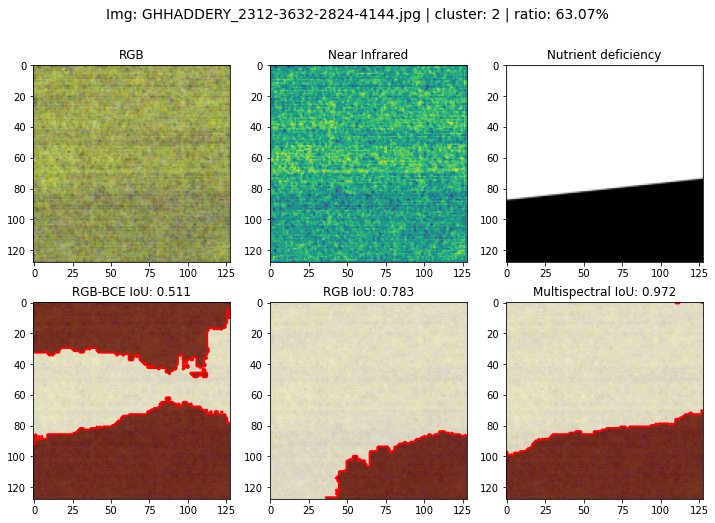

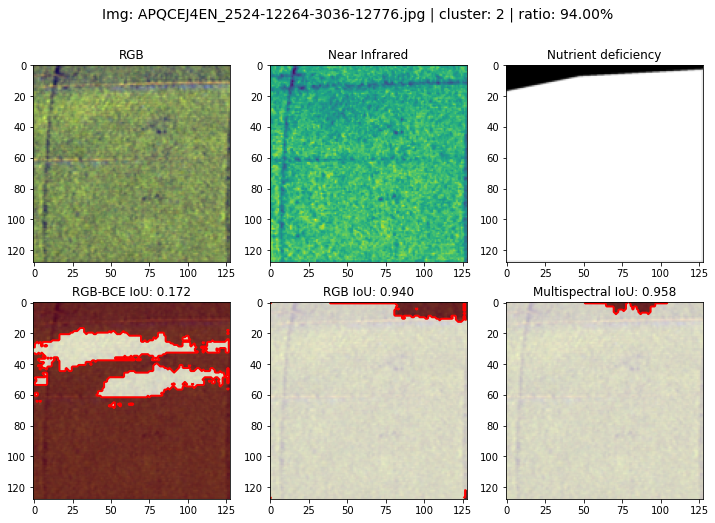

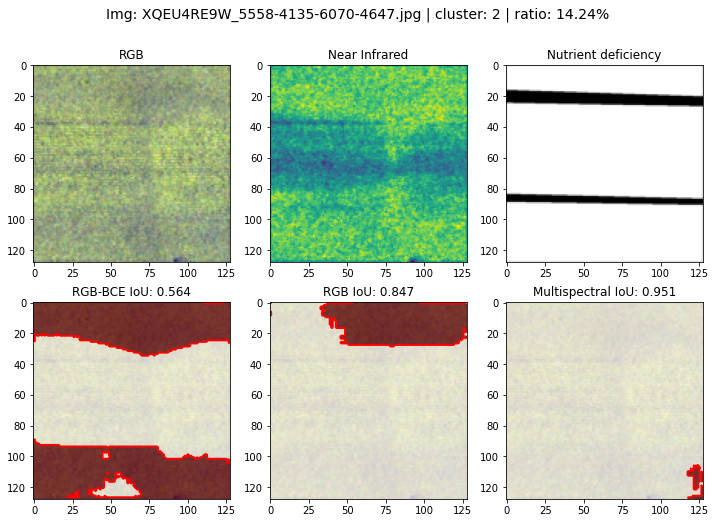

In [72]:
for img in [345,32,569]:
    plot_sample(best,img)
    plt.savefig('../images/eval/best_'+best.loc[img,'image_name']+'.png')

### The Okay Predictions:



In [73]:
okay = df.copy()
okay = okay[okay['IOU_MS'].between(0.4,0.6)].sort_values('IOU_MS')
display(okay[['nutrient_image_ratio','IOU_RGB_BCE','IOU_RGB','IOU_MS']].head(3))
display(okay[['nutrient_image_ratio','IOU_RGB_BCE','IOU_RGB','IOU_MS']].tail(3))

nutrient_image_ratio  IOU_RGB_BCE   IOU_RGB    IOU_MS
894               0.271896     0.099749  0.183081  0.401087
769               0.751995     0.230557  0.836011  0.401536
1006              0.441113     0.000000  0.350453  0.401846

nutrient_image_ratio  IOU_RGB_BCE   IOU_RGB    IOU_MS
2               0.661649     0.521444  0.638564  0.597721
97              0.345493     0.345719  0.391109  0.598552
52              0.288975     0.060473  0.444133  0.599877

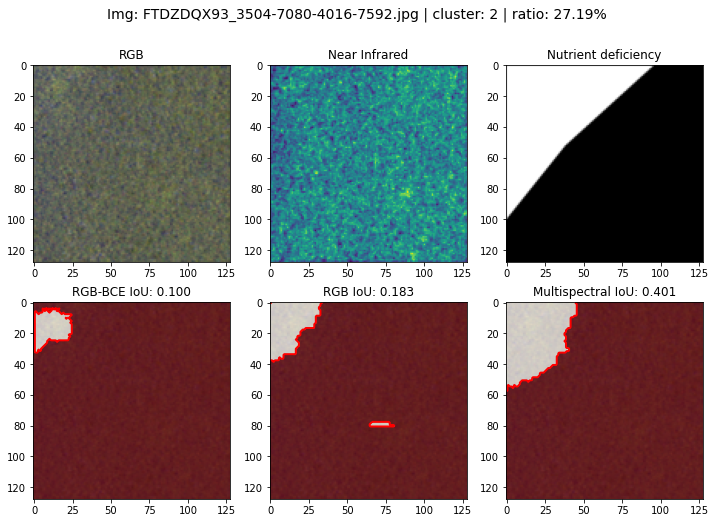

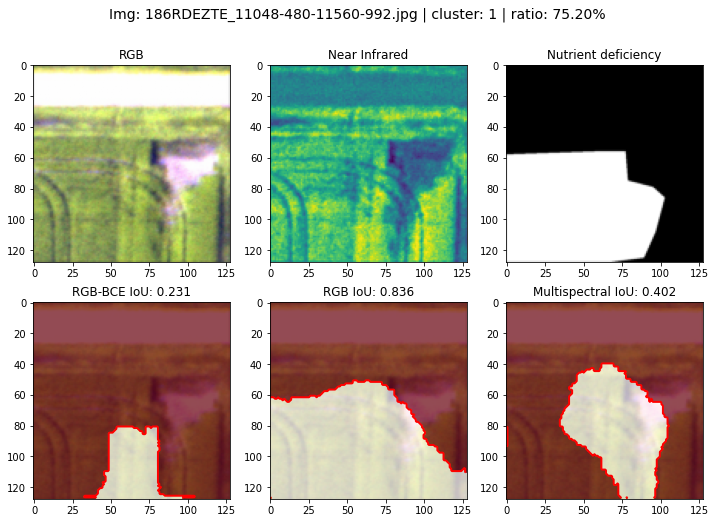

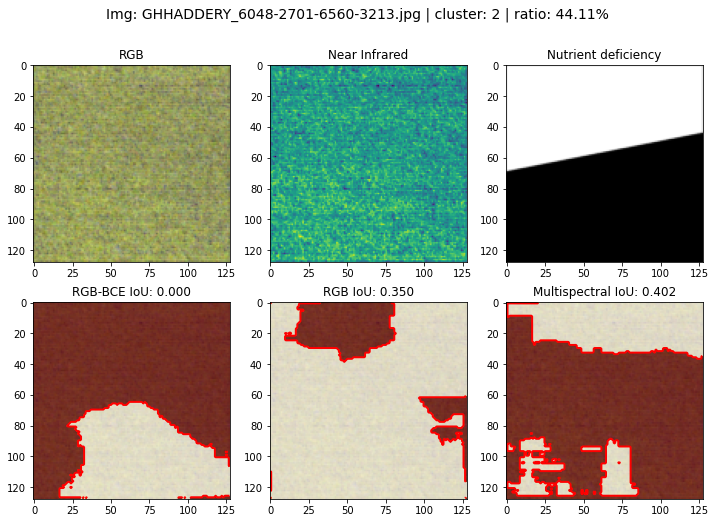

In [74]:
for img in [894,769,1006]:
    plot_sample(okay,img)
    plt.savefig('../images/eval/okay_better_'+okay.loc[img,'image_name']+'.png')

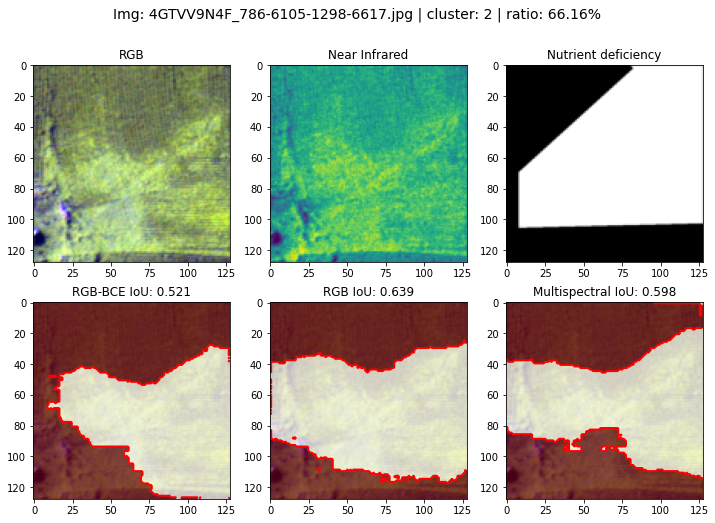

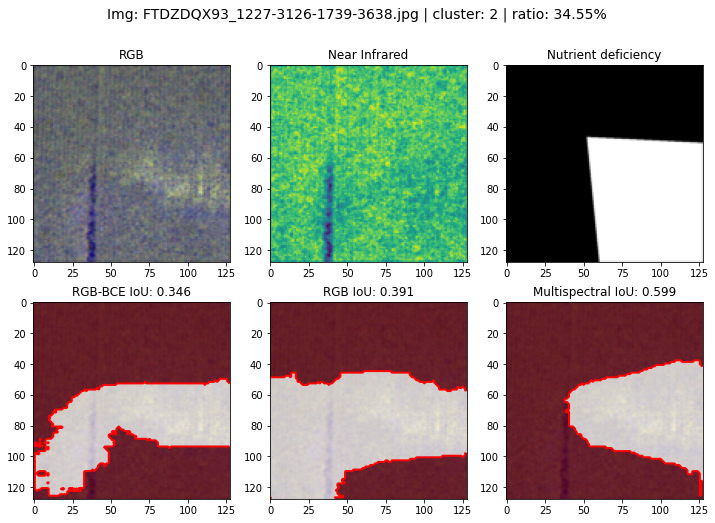

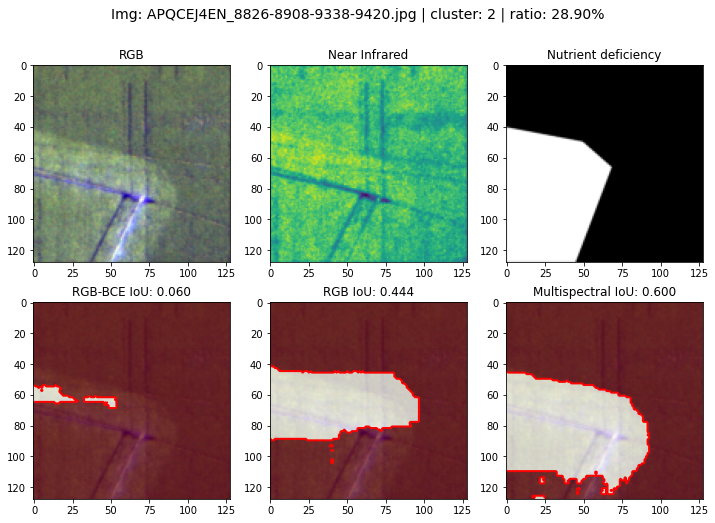

In [75]:
for img in [2,97,52]:
    plot_sample(okay,img)
    plt.savefig('../images/eval/okay_worse_'+okay.loc[img,'image_name']+'.png')

### The Bad Predictions:



In [76]:
#for some of the worst predictions, a warning about no boundaries to draw will emerge without the following two lines:
import warnings
warnings.filterwarnings("ignore")

worst = df.copy()
worst = worst[worst['IOU_MS']>0].sort_values('IOU_MS',ascending=True)
worst[['nutrient_image_ratio','IOU_RGB_BCE','IOU_RGB','IOU_MS']].head()


nutrient_image_ratio  IOU_RGB_BCE   IOU_RGB    IOU_MS
1433              0.562542     0.026598  0.334372  0.000221
922               0.043751     0.000000  0.000000  0.000234
1195              0.305729     0.308797  0.418731  0.000616
1284              0.404781     0.000000  0.382257  0.001387
327               0.106686     0.155869  0.193720  0.001470

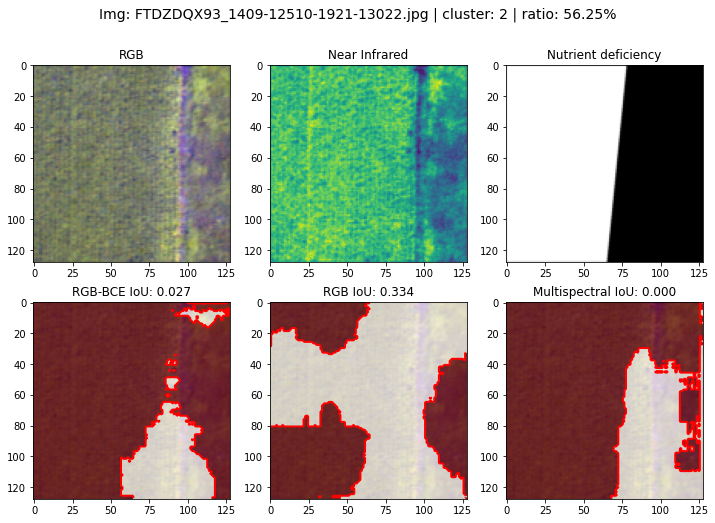

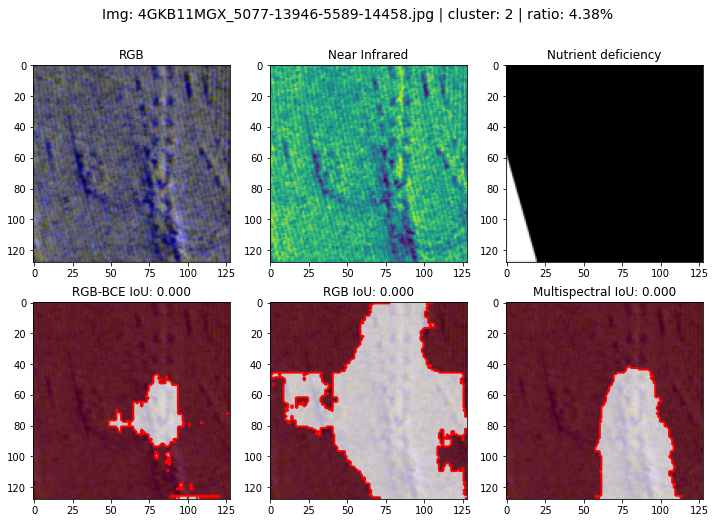

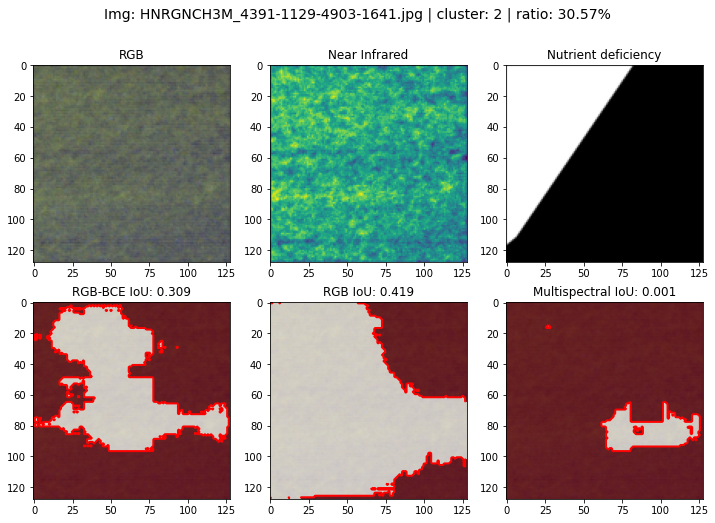

In [77]:
for img in [1433,922,1195]:
    plot_sample(worst,img)
    plt.savefig('../images/eval/worst_'+worst.loc[img,'image_name']+'.png')

---
## **Conclusions**

From the evaluation process, we can conclude a few key takeaways:
* Minding the metric for a given computer vision task is important; defaulting to binary crossentropy for a binary semantic segmentation task won't optimize the classification accuracy. The work above demonstrates that Intersection Over Union or the Jaccard Similarity might be a more compelling optimization metric.
* Using the Intersection over Union metric, our model (naive, and wanting for further enhancements) outperforms a baseline 'predictive' model that just assumes every pixel in the image is considered nutrient deficient.
* For agricultural applications in identifying nutrient deficiency, it's clear that sometimes the Near-Infrared spectral channel is helpful, but sometimes it's not.
* In some of the best examples above, appearance of nutrient deficiency may not be apparent to the human eye, but the UNET model used in this analysis shows machine learning has potential for aiding in the identification of nutrient deficiency.
    * With further model tuning and refinements, it's conceivable that a model like this could assist producers in the agriculture industry more rapidly identify and respond to nutrient deficiency in their farmplots.
    
## **Recommendations**
The model could use additional tuning and enhancements:
* The image data were originally provided in 512x512 size, but were resized to 128x128 for training (for computational expense minimization). With greater computing power and more time, the model could probably become even further developed in identifying nutrient deficiency. 
* Based on the conclusion, it's conceivable that an ensemble model might be beneficial for this type of task: in some cases the model using the near-infrared spectral channel performed worse at classification than the model that only used the RGB channels. This suggests that the two models are better in different situations, and their model output could potentially be used in an ensemble model to inform a model that takes on the best of both individual models.
* Lastly, RGB and near-infrared may not be the only imaging techniques that could be useful in this type of task. It could be beneficial to explore usage of other imaging measurements (like UV and Infrared).